# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: Invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Herpestes javanicus|Pacifastacus leniusculus|
|Acridotheres tristis|Humulus scandens|Parthenium hysterophorus|
|Ailanthus altissima|Hydrocotyle ranunculoides|Pennisetum setaceum|
|Alopochen aegyptiaca|Impatiens glandulifera|Perccottus glenii|
|Alternanthera philoxeroides|Lagarosiphon major|Persicaria perfoliata|
|Andropogon virginicus|Lepomis gibbosus|Plotosus lineatus|
|Arthurdendyus triangulatus|Lespedeza cuneata|Procambarus clarkii|
|Asclepias syriaca|Lithobates catesbeianus|Procambarus fallax|
|Baccharis halimifolia|Ludwigia peploides|Procyon lotor|
|Cabomba caroliniana|Lygodium japonicum|Prosopis juliflora|
|Callosciurus erythraeus|Lysichiton americanus|Pseudorasbora parva|
|Cardiospermum grandiflorum|Microstegium vimineum|Pueraria montana|
|Cortaderia jubata|Muntiacus reevesi|Salvinia molesta|
|Corvus splendens|Myocastor coypus|Sciurus carolinensis|
|Ehrharta calycina|Myriophyllum aquaticum|Sciurus niger|
|Eichhornia crassipes|Myriophyllum heterophyllum|Tamias sibiricus|
|Elodea nuttallii|Nasua nasua|Threskiornis aethiopicus|
|Eriocheir sinensis|Nyctereutes procyonoides|Trachemys scripta|
|Gunnera tinctoria|Ondatra zibethicus|Triadica sebifera|
|Gymnocoronis spilanthoides|Orconectes limosus|Vespa velutina|
|Heracleum mantegazzianum|Orconectes virilis||
|Heracleum persicum|Oxyura jamaicensis||

In [1902]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [1903]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot
import math

### Setting up some parameters

In [1904]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "visitsFlowersOf" #If you're not intersted in pollinators this will remove most of them
#interactionsToExclude = "interactsWith"    #Many interactions in GloBI do not specify a specific interaction. You can get a cleaner netwot by excluding them
interactionsToExclude = ""

In [1905]:

## Define the country of interest
country  = 'Belgium'

## The occurrence cube has data for each year, but here we aggreagate years to get a more complete measure of occupancy.
## This parameter defines the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used#
# A script to create cube.db is here https://github.com/AgentschapPlantentuinMeise/occcube
database = r"..\..\data\cube.db" 

## A script to create globi.db is here https://github.com/AgentschapPlantentuinMeise/createGlobiDB
## Define the place to find the interaction data
globiDB = r"..\..\createGlobiDB\globi.db"

### Define the taxon for the notebook for which to find all interactions


In [1906]:
taxon=input()

Pennisetum setaceum


In [1907]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [1908]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [1909]:
fullScientificName = match['scientificName']
print('The taxon to be studied is ' + fullScientificName)


The taxon to be studied is Pennisetum setaceum (Forssk.) Chiov.


### Just for information take a look at the interactions that the taxon has

In [1910]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [1911]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
sourceInteractions = curGlobi.fetchall()

In [1912]:
sourceInteractions

[]

In [1913]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
targetInteractions = curGlobi.fetchall()
targetInteractions

[('hasHost', 2), ('interactsWith', 8), ('parasiteOf', 1)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [1914]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [1915]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [1916]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

11

In [1917]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [1918]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [1919]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [1920]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

4

In [1921]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

5

In [1922]:
primaryInteractingTaxa

0    Aleurocybotus occiduus
1           Nezara viridula
8      Oligosita balcluthae
9     Heterodera orientalis
0       Pennisetum setaceum
dtype: object

## A function to query the globi database

In [1923]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [1924]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [1925]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [1926]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [1927]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [1928]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [1929]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [1930]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
        'sourceTaxonFamilyName', 'interactionTypeName',
        'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI',
        'sourceTaxonKingdomName','sourceTaxonKingdomId', 'targetTaxonKingdomName','targetTaxonKingdomId'                                        
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [1931]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [1932]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

93

In [1933]:
allInteractingTaxa.head()

0    Aleurocybotus occiduus
1           Nezara viridula
8      Oligosita balcluthae
9     Heterodera orientalis
0                          
dtype: object

In [1934]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
interactsWith    208
parasiteOf        98
eats              81
hasHost           13
pathogenOf         6
preysOn            1
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [1935]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [1936]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Citation for the GBIF Backbone Taxonomy

In [1937]:
from datetime import date
print("GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on ", date.today())

GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on  2020-07-24


### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [1938]:
taxaFound = {}
kingdom = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
        kingdom[name[1]] = GBIFName['kingdom']

    

Taxa from GLoBI, but not found in GBIF

Ficus carica


In [1939]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [1940]:
len(taxaFound)

93

In [1941]:
kingdom

{'Aleurocybotus occiduus': 'Animalia',
 'Nezara viridula': 'Animalia',
 'Oligosita balcluthae': 'Animalia',
 'Heterodera orientalis': 'Animalia',
 'Encarsia luteola': 'Animalia',
 'Euderomphale hyalina': 'Animalia',
 'Phaseolus coccineus': 'Plantae',
 'Aridelus rufotestaceus': 'Animalia',
 'Podarcis muralis': 'Animalia',
 'Xenoencyrtus niger': 'Animalia',
 'Xenoencyrtus rubricatus': 'Animalia',
 'Ooencyrtus pityocampae': 'Animalia',
 'Ooencyrtus submetallicus': 'Animalia',
 'Anastatus japonicus': 'Animalia',
 'Ooencyrtus nezarae': 'Animalia',
 'Ooencyrtus johnsoni': 'Animalia',
 'Ooencyrtus californicus': 'Animalia',
 'Ooencyrtus anasae': 'Animalia',
 'Emersonella niveipes': 'Animalia',
 'Ooencyrtus papilionis': 'Animalia',
 'Ooencyrtus fecundus': 'Animalia',
 'Hexacladia hilaris': 'Animalia',
 'Anastatus dasyni': 'Animalia',
 'Anastatus bifasciatus': 'Animalia',
 'Ooencyrtus nigerrimus': 'Animalia',
 'Ooencyrtus telenomicida': 'Animalia',
 'Ooencyrtus utetheisae': 'Animalia',
 'Tricho

### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [1942]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [1943]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [1944]:
year

2000

In [1945]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Aleurocybotus occiduus
Nezara viridula
Nezara viridula with key 2078852 occurs in 174 km squares.
Oligosita balcluthae
Heterodera orientalis

Encarsia luteola
Euderomphale hyalina
Phaseolus coccineus
Aridelus rufotestaceus
Podarcis muralis
Podarcis muralis with key 2469188 occurs in 457 km squares.
Xenoencyrtus niger
Xenoencyrtus rubricatus
Ooencyrtus pityocampae
Ooencyrtus submetallicus
Anastatus japonicus
Ooencyrtus nezarae
Ooencyrtus johnsoni
Ooencyrtus californicus
Ooencyrtus anasae
Emersonella niveipes
Ooencyrtus papilionis
Ooencyrtus fecundus
Hexacladia hilaris
Anastatus dasyni
Anastatus bifasciatus
Ooencyrtus nigerrimus
Ooencyrtus telenomicida
Ooencyrtus utetheisae
Trichopoda lanipes
Trichopoda pennipes
Beauveria bassiana
Metarhizium anisopliae
Klebsiella pneumoniae
Pennisetum setaceum
Pennisetum setaceum with key 2706134 occurs in 0 km squares.
Cynodon dactylon
Cynodon dactylon with key 6109637 occurs in 180 km squares.
Distichlis spicata
Stenotaphrum secundatum
Hordeum vulgare

In [1946]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [1947]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 37


In [1948]:
taxaFoundInCountry

,count,key,species
0,174,2078852,Nezara viridula
1,457,2469188,Podarcis muralis
2,0,2706134,Pennisetum setaceum
3,180,6109637,Cynodon dactylon
4,222,2706056,Hordeum vulgare
5,785,2930137,Solanum lycopersicum
6,10,5380041,Ricinus communis
7,973,7903057,Brassica rapa
8,1919,2993094,Rubus idaeus
9,95,2874508,Cucurbita pepo


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [1949]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [1950]:
# Create graphic object
G = nx.DiGraph()

In [1951]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [1952]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Bombus hortorum')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI,sourceTaxonKingdomName,sourceTaxonKingdomId,targetTaxonKingdomName,targetTaxonKingdomId


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [1953]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

8349


### Add the nodes to the graph

In [1954]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    #The square root ensures that the node area is proportional to the occupancy, rather than the radius
    dictOfNodeSizes[row['species']] = math.sqrt(int(row['count']/maxRecords*100))*10

### Add edges to the graph

In [1955]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Pennisetum setaceum Nezara viridula interactsWith
C:  Pennisetum setaceum Nezara viridula interactsWith
C:  Pennisetum setaceum Nezara viridula interactsWith
C:  Pennisetum setaceum Nezara viridula interactsWith
C:  Pennisetum setaceum Nezara viridula interactsWith
C:  Pennisetum setaceum Nezara viridula interactsWith
C:  Solanum lycopersicum Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Brassica rapa Nezara viridula interactsWith
C:  Solanum lycopersicum Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Ricinus communis Nezara viridula interactsWith
C:  Rici

In [1956]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Podarcis muralis Nezara viridula eats
F:  Nezara viridula Pennisetum setaceum interactsWith
F:  Nezara viridula Pennisetum setaceum interactsWith
F:  Nezara viridula Pennisetum setaceum interactsWith
F:  Nezara viridula Pennisetum setaceum interactsWith
F:  Nezara viridula Pennisetum setaceum interactsWith
F:  Nezara viridula Pennisetum setaceum interactsWith
F:  Nezara viridula Solanum lycopersicum interactsWith
F:  Nezara viridula Solanum lycopersicum interactsWith
F:  Nezara viridula Solanum lycopersicum interactsWith
F:  Nezara viridula Solanum lycopersicum interactsWith
F:  Nezara viridula Solanum lycopersicum interactsWith
F:  Nezara viridula Solanum lycopersicum interactsWith
F:  Nezara viridula Solanum lycopersicum eats
F:  Nezara viridula Ricinus communis interactsWith
F:  Nezara viridula Ricinus communis interactsWith
F:  Nezara viridula Ricinus communis interactsWith
F:  Nezara viridula Ricinus communis interactsWith
F:  Nezara viridula Ricinus communis interactsWith
F: 

In [1957]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 37
Number of edges = 35


In [1958]:
len(dictOfNodeSizes)

37

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [1959]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [1960]:
len(G.nodes)

34

## Remove any selfloop edges

In [1961]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [1962]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

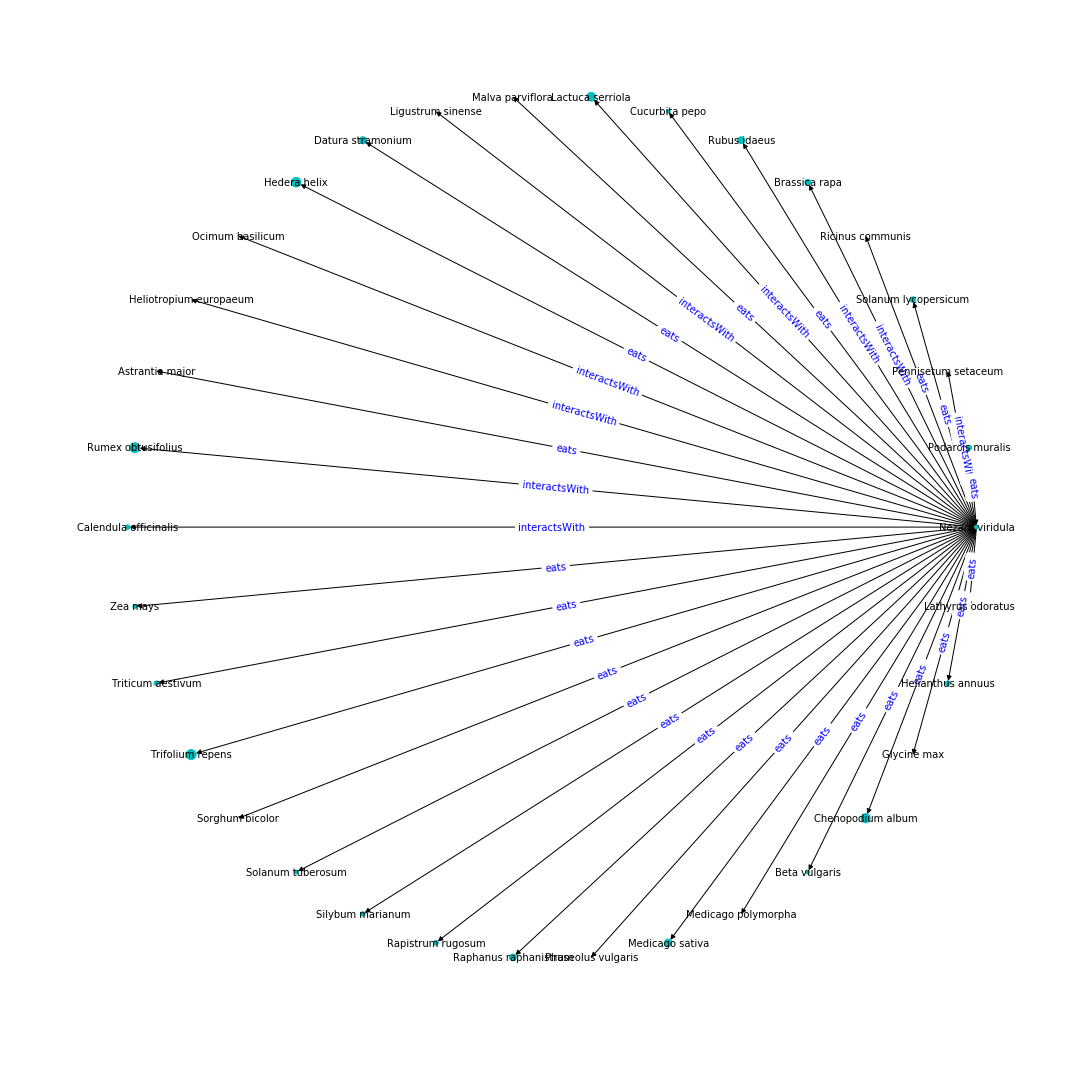

In [1963]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

#pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [1964]:
filename = "..\\docs\\"+taxon+country+".html"
with open(filename, "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
.red {color: red; font-style: bold;} \
.green {color: green; font-style: bold;} \
.blue {color: red; font-style: bold;} \
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [1965]:
with open(filename, "a") as file:
    if len(G.nodes)==0:
        file.write("<p>No interacting species have been found for "+taxon+" in "+country+".<br />") 
    else:
        file.write("<p>Nodes can be moved and if clicked on open a tab with species details<br />") 
        file.write("<p>The target species is the <SPAN CLASS='red'>red node</SPAN>. <em>Plantae</em> are <SPAN CLASS='green'>green</SPAN>, <em>Animalia</em> are <SPAN CLASS='blue'>blue</SPAN> and everything else is brown<br />") 
        file.write("<p>Node area is proportional to the 1 km<sup>2</sup> occupancy<br />") 
    file.write("<p>All <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that <em>"+taxon+"</em> has with other taxa</p>")
    

In [1966]:
species = G.nodes
#with open(filename, "a") as file:
#    for n in species:
#        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")

In [1967]:
with open(filename, "a") as file: 
    if len(sourceInteractions) != 0:
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in sourceInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&sourceTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n")
        file.write("</table>") 
    if len(targetInteractions) != 0:
        file.write("<p>All <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that other taxa have with <em>"+taxon+"</em></p>")
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in targetInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&targetTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n") 
        file.write("</table>")
    file.write("<a href='https://github.com/AgentschapPlantentuinMeise/interactias'><img src='Octocat.jpg' alt='GitHub logo' width='160' height='133'><p>Find the code on GitHub</p></a>")

In [1968]:
file.close()

In [1969]:
with open(filename, "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [1970]:
file = open(filename, "a")
for n in species:
    if n == taxon:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: true,},\n")
    else:
        file.write("{ data: { id: '"+n+"', kingdom: '"+kingdom[n]+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: false,},\n")
file.close()

### Write edges to file

In [1971]:
file = open(filename, "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', href: 'https://www.globalbioticinteractions.org/?interactionType="+str(nx.get_edge_attributes(G, 'label')[edge])+"&sourceTaxon="+edge[0]+"&targetTaxon="+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [1972]:
with open(filename, "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'yellow', \n\
                label: 'data(id)', \n\
                'text-valign': 'center', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '8px', \n\
                'border-width': '0.5', \n\
                'border-color': 'black', \n\
                'width': 'mapData(occnum, 0, 400, 3, 200)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 200)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '6px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
         },  \n\
         {  \n\
              selector: '[kingdom = \"Plantae\"]',   \n\
              css: {  \n\
                'background-color': 'lightgreen'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: '[kingdom = \"Animalia\"]',   \n\
              css: {  \n\
                'background-color': 'lightblue'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'shape': 'square',  \n\
                'background-color': 'red'  \n\
                 }  \n\
        }], \n\
layout:  { \n\
            name: 'cose-bilkent', padding: 1, animate: true, gravity: 30, animationDuration: 3000 \n\
     } \n\
} \n\
); \n\
")

In [1973]:
with open(filename, "a") as file:
    file.write("cy.userZoomingEnabled( true ); \n\
    cy.getElementById('"+taxon+"').select(); \n\
    document.write('<br />Degree of node <em>"+fullScientificName+"</em> = '+cy.getElementById('"+taxon+"').degree()); \n\
    cy.on('tap', 'node', function(){ \n\
        try { // your browser may block popups \n\
              window.open( this.data('href') ); \n\
            } catch(e){ // fall back on url change \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
    cy.on('tap', 'edge', function(){  \n\
        try { // your browser may block popups  \n\
              window.open( this.data('href') );  \n\
            } catch(e){ // fall back on url change  \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
</script> \n\
")

In [1974]:
with open(filename, "a") as file:
    file.write("</ul> \
        </body> \
        </html>")

In [1975]:
file.close()

In [1976]:
#with open(filename, "a") as file:
#    file.write("<h2>References</h2><ul>\n")

In [1977]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
#file = open(filename, "a")
for ref in citations:
    print("* ",str(ref))
#    file.write("<li>"+str(ref)+"</li>\n")
#file.close()

*  Digital Bee Collections Network, 2014 (and updates). Version: 2015-03-18. National Science Foundation grant DBI 0956388; PBI: Phytophagous Insects as a Model Group for Documenting Planetary Biodiversity (Insecta: Heteroptera: Miridae: Orthotylinae, Phylinae). Version: 08 Mar 2016. National Science Foundation grant DBI#0316495; Tri-Trophic Thematic Collection Network, 2014 (and updates). Version: 08 Mar 2016. http://tcn.amnh.org/. National Science Foundation grant(s) EF#1115081, EF#1115103, EF#1115080, EF#1115144, EF#1115191, EF#1115104, EF#1115115
*  Ed Baker; Ian J. Kitching; George W. Beccaloni; Amoret Whitaker et al. (2016). Dataset: NHM Interactions Bank. Natural History Museum Data Portal (data.nhm.ac.uk). https://doi.org/10.5519/0060767
*  Sarah E Miller. 4/18/2016. Species associations from Wardeh, M. et al. Database of host-pathogen and related species interactions, and their global distribution. Sci. Data 2:150049 doi: 10.1038/sdata.2015.49 (2015)
*  A. Thessen. 2014. Speci

### For import into Gephi: A nodes and edges file has been replace by the .dot file format

In [1978]:
write_dot(G, "..\\docs\\"+taxon+".dot")